In [1]:
# %%
# %%
import os
import jax

# 设置环境变量
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda"
os.environ["JAX_PLATFORM_NAME"] = "gpu"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

import os
os.environ['NETKET_EXPERIMENTAL_SHARDING'] = '1'

import netket as nk
import jax
print("启用分片模式：", nk.config.netket_experimental_sharding)
print("可用设备：", jax.devices())


启用分片模式： True
可用设备： [CudaDevice(id=0), CudaDevice(id=1)]


In [2]:

# %%
# %%
import os
import logging
import sys
import jax
import netket as nk
import numpy as np
import matplotlib.pyplot as plt
import time
import json
import netket.nn as nknn
import flax
import flax.linen as nn
import jax.numpy as jnp
import math
from math import pi
from functools import partial
from netket.nn import log_cosh
from einops import rearrange
from netket.utils.group.planar import rotation, reflection_group, D, glide, glide_group, C
from netket.utils.group import PointGroup, Identity, PermutationGroup
from netket.operator.spin import sigmax, sigmay, sigmaz
from netket.optimizer.qgt import QGTJacobianPyTree, QGTJacobianDense, QGTOnTheFly
from netket.operator import AbstractOperator
from netket.vqs import VariationalState
from scipy import sparse as _sparse
from netket.utils.types import DType as _DType
from netket.hilbert import DiscreteHilbert as _DiscreteHilbert
from netket.operator import LocalOperator as _LocalOperator
from tqdm.notebook import tqdm
from jax import tree
from netket.nn.blocks import SymmExpSum


In [3]:
# ---------------------------
# Convolutional Unit
# ---------------------------
class ConvUnit(nn.Module):
    d_model: int

    @nn.compact
    def __call__(self, x):
        # x shape: [batch, n_tokens, d_model]
        batch, n_tokens, d_model = x.shape
        grid = int(np.sqrt(n_tokens))
        x_grid = x.reshape(batch, grid, grid, d_model)
        conv_out = nn.Conv(features=self.d_model,
                           kernel_size=(3, 3),
                           padding="SAME",
                           kernel_init=nn.initializers.xavier_uniform(),
                           param_dtype=jnp.float64,
                           dtype=jnp.float64)(x_grid)
        conv_out = nn.gelu(conv_out)
        out = conv_out.reshape(batch, n_tokens, d_model)
        return out

# ---------------------------
# Multi-Head Self-Attention with Relative Position Encoding
# ---------------------------
class CT_MHSA(nn.Module):
    d_model: int
    h: int
    n_tokens: int  # Number of tokens (should be a square number for 2D grid)
    
    def setup(self):
        self.d_head = self.d_model // self.h
        # Linear projections for Q, K, V.
        self.WQ = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                           param_dtype=jnp.float64, dtype=jnp.float64)
        self.WK = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                           param_dtype=jnp.float64, dtype=jnp.float64)
        self.WV = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                           param_dtype=jnp.float64, dtype=jnp.float64)
        # Relative positional encoding parameter: shape [h, n_tokens, n_tokens]
        self.P = self.param("RPE", nn.initializers.xavier_uniform(), 
                            (self.h, self.n_tokens, self.n_tokens), jnp.float64)
        self.WO = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                           param_dtype=jnp.float64, dtype=jnp.float64)

    def __call__(self, x):
        batch, n, _ = x.shape

        Q = self.WQ(x)  # [batch, n, d_model]
        K = self.WK(x)
        V = self.WV(x)
        Q = rearrange(Q, 'b n (h d) -> b h n d', h=self.h)
        K = rearrange(K, 'b n (h d) -> b h n d', h=self.h)
        V = rearrange(V, 'b n (h d) -> b h n d', h=self.h)
        scale = np.sqrt(self.d_head)
        attn_scores = jnp.einsum('bhid,bhjd->bhij', Q, K)  # [batch, h, n, n]
        attn_scores = attn_scores / scale + self.P  # 添加RPE，保持平移不变性
        attn = nn.softmax(attn_scores, axis=-1)
        attn_out = jnp.einsum('bhij,bhjd->bhid', attn, V)
        attn_out = rearrange(attn_out, 'b h n d -> b n (h d)')
        out = self.WO(attn_out)
        return out

# ---------------------------
# Inverted Residual Feed-Forward Network (IRFFN)
# ---------------------------
class IRFFN(nn.Module):
    d_model: int
    expansion_factor: int = 2  # 可调扩展因子

    @nn.compact
    def __call__(self, x):
        # x: [batch, n_tokens, d_model]
        batch, n_tokens, d_model = x.shape
        grid = int(np.sqrt(n_tokens))
        expanded_dim = self.expansion_factor * self.d_model
        
        # 线性投影，将维度扩展为 expansion_factor * d_model
        hidden = nn.Dense(expanded_dim, 
                          kernel_init=nn.initializers.xavier_uniform(),
                          param_dtype=jnp.float64, 
                          dtype=jnp.float64)(x)
        hidden = nn.gelu(hidden)
        
        # 调整为2维空间的形状：grid x grid
        hidden = hidden.reshape(batch, grid, grid, expanded_dim)
        
        # 使用group convolution实现depthwise convolution, groups=channels
        hidden = nn.Conv(features=expanded_dim,
                         kernel_size=(3, 3),
                         padding="SAME",
                         feature_group_count=expanded_dim,
                         kernel_init=nn.initializers.xavier_uniform(),
                         param_dtype=jnp.float64,
                         dtype=jnp.float64)(hidden)
        hidden = nn.gelu(hidden)
        
        # 恢复为原token维度：[batch, n_tokens, expanded_dim]
        hidden = hidden.reshape(batch, n_tokens, expanded_dim)
        
        # 线性映射回 d_model 维度
        out = nn.Dense(self.d_model, 
                       kernel_init=nn.initializers.xavier_uniform(),
                       param_dtype=jnp.float64, 
                       dtype=jnp.float64)(hidden)
        return out



# ---------------------------
# CTWF Encoder Block
# ---------------------------
class EncoderCTWF(nn.Module):
    d_model: int
    h: int
    n_tokens: int

    @nn.compact
    def __call__(self, x):
        # 1. Convolutional Unit with LayerNorm and residual connection
        norm1 = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)(x)
        conv_out = ConvUnit(self.d_model)(norm1)
        x = x + conv_out

        # 2. Multi-Head Self-Attention with LayerNorm and residual connection
        norm2 = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)(x)
        attn_out = CT_MHSA(self.d_model, self.h, self.n_tokens)(norm2)
        x = x + attn_out

        # 3. Inverted Residual Feed-Forward Network with LayerNorm and residual connection
        norm3 = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)(x)
        ffn_out = IRFFN(self.d_model)(norm3)
        x = x + ffn_out

        return x


# ---------------------------
# Output Head
# ---------------------------
class OutputHead(nn.Module):
    d_model: int

    def setup(self):
        self.out_layer_norm = nn.LayerNorm(dtype=jnp.float64, param_dtype=jnp.float64)
        self.norm0 = nn.LayerNorm(use_scale=True, use_bias=True,
                                  dtype=jnp.float64, param_dtype=jnp.float64)
        self.norm1 = nn.LayerNorm(use_scale=True, use_bias=True,
                                  dtype=jnp.float64, param_dtype=jnp.float64)
        self.output_layer0 = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                                      bias_init=jax.nn.initializers.zeros,
                                      param_dtype=jnp.float64, dtype=jnp.float64)
        self.output_layer1 = nn.Dense(self.d_model, kernel_init=nn.initializers.xavier_uniform(),
                                      bias_init=jax.nn.initializers.zeros,
                                      param_dtype=jnp.float64, dtype=jnp.float64)

    def __call__(self, x):
        # 汇聚token的信息，进行归一化处理后得到振幅和符号部分，并使用 log_cosh 激活
        z = self.out_layer_norm(x.sum(axis=1))
        amp = self.norm0(self.output_layer0(z))
        sign = self.norm1(self.output_layer1(z))
        out = amp + 1j * sign
        return jnp.sum(log_cosh(out), axis=-1)

# ---------------------------
# Overall CTWF Network with Convolutional Embed
# ---------------------------
class CTWFNQS(nn.Module):
    num_layers: int
    d_model: int
    heads: int
    n_sites: int         # 总格点数，例如 L x L
    patch_size: int      # Patch 尺寸

    def setup(self):
        # 输入为一维展开的格点数据，重构为二维时的边长
        self.L = int(np.sqrt(self.n_sites))
        # 经过卷积嵌入后，输出尺度为 (L/patch_size) x (L/patch_size)
        self.n_tokens_side = self.L // self.patch_size
        self.n_tokens = self.n_tokens_side * self.n_tokens_side
        # Embedding using convolution: kernel_size 和 strides 均为 patch_size
        self.embed = nn.Conv(features=self.d_model,
                             kernel_size=(self.patch_size, self.patch_size),
                             strides=(self.patch_size, self.patch_size),
                             padding="VALID",
                             kernel_init=nn.initializers.xavier_uniform(),
                             param_dtype=jnp.float64,
                             dtype=jnp.float64)
        # 堆叠多层 CTWF encoder blocks
        self.blocks = [EncoderCTWF(d_model=self.d_model,
                                     h=self.heads,
                                     n_tokens=self.n_tokens)
                       for _ in range(self.num_layers)]
        self.output = OutputHead(self.d_model)

    def __call__(self, spins):
        # spins shape: [batch, n_sites]，其中 n_sites = L^2
        x = jnp.atleast_2d(spins)
        batch = x.shape[0]
        # 重构为二维格点，并增加 channel 维度（例如1）
        x = x.reshape(batch, self.L, self.L, 1)
        # 进行卷积嵌入，输出 shape: [batch, n_tokens_side, n_tokens_side, d_model]
        x = self.embed(x)
        # Flatten成 token 序列: [batch, n_tokens, d_model]
        x = x.reshape(batch, self.n_tokens, self.d_model)
        # 依次通过 encoder block
        for block in self.blocks:
            x = block(x)
        # 利用 output head 汇聚信息输出标量（波函数对数幅值）
        out = self.output(x)
        return out


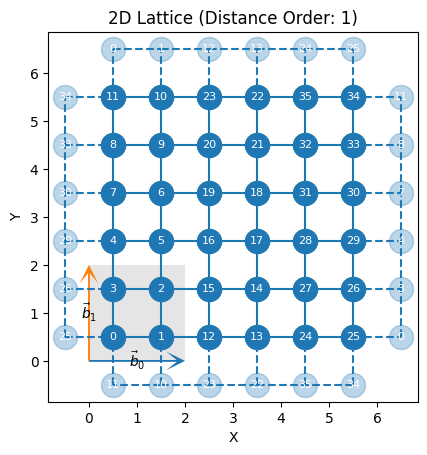

In [4]:
# 哈密顿量参数
J1 = 0.8
J2 = 1.0
Q = 0  # 四自旋相互作用强度，替换h项

# Shastry-Sutherland晶格定义
Lx = 3
Ly = 3

# 自定义边
custom_edges = [
    (0, 1, [1.0, 0.0], 0),
    (1, 0, [1.0, 0.0], 0),
    (1, 2, [0.0, 1.0], 0),
    (2, 1, [0.0, 1.0], 0),
    (3, 2, [1.0, 0.0], 0),
    (2, 3, [1.0, 0.0], 0),
    (0, 3, [0.0, 1.0], 0),
    (3, 0, [0.0, 1.0], 0),
    (2, 0, [1.0, -1.0], 1),
    (3, 1, [1.0, 1.0], 1),
]

# 创建晶格
lattice = nk.graph.Lattice(
    basis_vectors=[[2.0, 0.0], [0.0, 2.0]],
    extent=(Lx, Ly),
    site_offsets=[[0.5, 0.5], [1.5, 0.5], [1.5, 1.5], [0.5, 1.5]],
    custom_edges=custom_edges,
    pbc=[True, True]
)

# 可视化晶格
lattice.draw()

# %%
# Hilbert空间定义
hi = nk.hilbert.Spin(s=1/2, N=lattice.n_nodes, total_sz=0)

# 自旋-1/2矩阵
sigmax = jnp.array([[0, 0.5], [0.5, 0]])
sigmay = jnp.array([[0, -0.5j], [0.5j, 0]])
sigmaz = jnp.array([[0.5, 0], [0, -0.5]])
unitm = jnp.array([[1.0, 0.0], [0.0, 1.0]])

# 自旋-自旋相互作用
sxsx = np.kron(sigmax, sigmax)
sysy = np.kron(sigmay, sigmay)
szsz = np.kron(sigmaz, sigmaz)
umum = np.kron(unitm, unitm)
SiSj = sxsx + sysy + szsz

# Q项需要的C_ij算子定义
Cij = 0.25 * umum - SiSj
Cij2 = np.kron(Cij, Cij)  # 四自旋交互项

# 构建J1-J2部分的哈密顿量
bond_operator = [
    (J1 * SiSj).tolist(),
    (J2 * SiSj).tolist(),
]
bond_color = [0, 1]

# 创建图哈密顿量 - 不包含Q项
H_J = nk.operator.GraphOperator(hi, graph=lattice, bond_ops=bond_operator, bond_ops_colors=bond_color)

# 创建Q项哈密顿量
H_Q = nk.operator.LocalOperator(hi, dtype=jnp.complex128)

# 添加四自旋Q项 - 每个单元格(plaquette)上的四自旋相互作用
for unit_x in range(Lx):
    for unit_y in range(Ly):
        # 找到单元格中的4个顶点
        base_idx = 4 * (unit_x + unit_y * Lx)
        plaq_sites = [
            base_idx,                  # 左下角 (0.5, 0.5) 
            base_idx + 1,              # 右下角 (1.5, 0.5)
            base_idx + 2,              # 右上角 (1.5, 1.5)
            base_idx + 3               # 左上角 (0.5, 1.5)
        ]
        
        # 两种不同的顺序添加四自旋相互作用Q项
        # 按照顺时针方向连接
        sites_clockwise = [plaq_sites]
        operatorQ = [(-Q * Cij2).tolist()]
        H_Q += nk.operator.LocalOperator(hi, operatorQ, sites_clockwise)
        
        # 按照交叉方向连接
        sites_cross = [[plaq_sites[0], plaq_sites[2], plaq_sites[1], plaq_sites[3]]]
        H_Q += nk.operator.LocalOperator(hi, operatorQ, sites_cross)

# 合并两部分哈密顿量
ha = H_J + H_Q
ha = ha.to_jax_operator()


In [ ]:
# ----------------- 构造CTWF量子态 -----------------
# 这里设置 patch_size 为2，令 L_eff = n_sites / (2^2)。对于Shastry-Sutherland晶格，
# n_sites = Lx * Ly * 4 = 36 -> L_eff = 9。
# 按照论文参数：d_model=18, h=2，且堆叠1层CTWF Block
# 使用增强位置编码的方式初始化CTWF模型
# 例如，使用2D位置编码：

model_no_symm = CTWFNQS(
    num_layers=4,
    d_model=32,
    heads=4,
    n_sites=lattice.n_nodes,
    patch_size=2
)


# 对称化（这里采用平移及旋转对称性）
nc = 4
cyclic_4 = PointGroup(
    [Identity()] + [rotation((360 / nc)*i) for i in range(1, nc)],
    ndim=2,
)
C4v = glide_group(trans=(1, 1), origin=(0, 0)) @ cyclic_4
C4v_symmetry = lattice.space_group(C4v)
# # 平移对称性
# trans_symmetry = lattice.translation_group()

# D4对称性
d4_group = D(4)

# 定义新的对称中心
new_origin = np.array([1.0, 1.0])

# 调整对称群，以 new_origin 为新的旋转中心
new_d4_group = d4_group.change_origin(new_origin)
D4_symmetry = lattice.point_group(new_d4_group)


symmetries=C4v_symmetry
print(f"Number of symmetry operations: {len(symmetries)}")


from netket.nn.blocks import SymmExpSum
model = SymmExpSum(
    module=model_no_symm,
    symm_group=symmetries,
    character_id=None
)


Number of symmetry operations: 72


In [6]:
# ----------------- 训练设置 -----------------
sampler = nk.sampler.MetropolisExchange(hilbert=hi, graph=lattice, n_chains=2**12, d_max=2)

# 使用MCState构造变分量子态
vqs = nk.vqs.MCState(
    sampler=sampler,
    model=model,
    n_samples=2**12,
    n_samples_per_rank=None,
    n_discard_per_chain=0,
    chunk_size=2**8,
    training_kwargs={"holomorphic": False}  # 非全纯函数
)

n_params = nk.jax.tree_size(vqs.parameters)
print(f"Number of model parameters: {n_params}")  # 应接近7884

Number of model parameters: 12408


In [ ]:

# %%
import time
import jax
import jax.numpy as jnp
from jax import tree_util
from tqdm.notebook import tqdm
from netket.experimental.driver.vmc_srt import VMC_SRt

# 定义熵梯度计算函数
def T_logp2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * jnp.mean(jnp.real(preds)**2)

def T_logp_2(params, inputs, temperature, model_instance):
    variables = {"params": params}
    preds = model_instance.apply(variables, inputs)
    return 2.0 * temperature * (jnp.mean(jnp.real(preds)))**2

# 基于 VMC_SRt 实现自由能 F = E - T*S 的优化
# ...existing code...
def clip_gradients(gradients, max_norm):
    # 将梯度中的叶子节点转换为列表
    grads_flat, tree_def = jax.tree_util.tree_flatten(gradients)
    # 计算全局范数
    global_norm = jnp.sqrt(sum([jnp.sum(jnp.square(g)) for g in grads_flat]))
    # 计算裁切系数
    clip_coef = jnp.minimum(1.0, max_norm / (global_norm + 1e-6))
    # 应用裁切
    return jax.tree_util.tree_map(lambda g: g * clip_coef, gradients)

class FreeEnergyVMC_SRt(VMC_SRt):
    def __init__(self, temperature, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # 记录初始温度，用于后续温度递减计算
        self.init_temperature = temperature
        self.temperature = temperature
        self.max_grad_norm = 1.0  # 最大范数，可以根据需要进行调整

    def _step_with_state(self, state):
        # 基础能量梯度更新步骤
        new_state = super()._step_with_state(state)
        params = new_state.parameters
        inputs = new_state.samples

        # 计算熵梯度部分
        mT_grad_S_1 = jax.grad(T_logp2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S_2 = jax.grad(T_logp_2, argnums=0)(params, inputs, self.temperature, self.variational_state.model)
        mT_grad_S = jax.tree_util.tree_map(lambda x, y: x - y, mT_grad_S_1, mT_grad_S_2)

        # 自由能梯度：能量梯度减去熵梯度
        total_grad = jax.tree_util.tree_map(lambda g_e, g_s: g_e - g_s, new_state.gradient, mT_grad_S)

        # 对梯度进行裁切
        total_grad = clip_gradients(total_grad, self.max_grad_norm)

        # 更新参数
        new_params = self.optimizer.update(total_grad, params)
        new_state = new_state.replace(parameters=new_params)
        return new_state
# ...existing code...


# 添加进度条以及温度递减方案
class CustomFreeEnergyVMC_SRt(FreeEnergyVMC_SRt):
    def __init__(self, reference_energy, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.reference_energy = reference_energy

    def run(self, n_iter, out=None):
        """运行优化并在 tqdm 进度条中显示 Temperature，Energy，E_var，E_err 和 Rel_err(%)"""
        outer_pbar = tqdm(total=n_iter, desc=f"Lx={Lx}, Ly={Ly}")
        for i in range(n_iter):
            # 更新温度：使用初始温度乘以递减因子
            self.temperature = self.init_temperature * (jnp.exp(-i / 50.0))
            self.advance(1)

            energy_mean = self.energy.mean
            energy_var = self.energy.variance
            energy_error = self.energy.error_of_mean
            relative_error = abs((energy_mean - self.reference_energy) / self.reference_energy) * 100

            outer_pbar.set_postfix({
                'Temp': f'{self.temperature:.4f}',
                'Energy': f'{energy_mean:.6f}', 
                'E_var': f'{energy_var:.6f}',
                'E_err': f'{energy_error:.6f}',
                'Rel_err(%)': f'{relative_error:.4f}',
            })
            outer_pbar.update(1)
        outer_pbar.close()
        return self
    


temperature_original = 1.0  # 初始温度
reference_energy = -16.2618
optimizer = nk.optimizer.Sgd(learning_rate=0.03)
# optimizer = nk.optimizer.Adam(learning_rate=0.03)



vmc = CustomFreeEnergyVMC_SRt(
    reference_energy=reference_energy,
    temperature=temperature_original,
    hamiltonian=ha,
    optimizer=optimizer,
    diag_shift=0.01,
    variational_state=vqs
)

start = time.time()
vmc.run(n_iter=1000)
end = time.time()
print(f"优化耗时: {end - start:.2f}秒")

Lx=3, Ly=3:   0%|          | 0/1000 [00:00<?, ?it/s]